In [24]:
import numpy as np
import sys, os
import matplotlib.pyplot as plt
from scipy.integrate import quad, nquad
from scipy.interpolate import interp1d
from astropy import units as u
from astropy.coordinates import SkyCoord
from tqdm import *
import pandas as pd
from scipy.stats import chi2
from scipy.special import sph_harm 
from scipy.special import lpmv
import healpy as hp
from healpy.sphtfunc import map2alm
from estimator_quadratic import QuadraticEstimator

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load

In [7]:
quasars_pd = pd.read_csv("../data/quasars_phot.csv")
quasars_pd.columns.values

array(['source_id', 'parallax', 'parallax_error', 'ra', 'dec', 'ra_error',
       'dec_error', 'pmra', 'pmdec', 'pmra_error', 'pmdec_error',
       'pmra_pmdec_corr', 'astrometric_gof_al',
       'astrometric_matched_observations', 'visibility_periods_used',
       'astrometric_sigma5d_max', 'radial_velocity',
       'radial_velocity_error', 'astrometric_n_good_obs_al',
       'astrometric_n_bad_obs_al', 'astrometric_excess_noise',
       'astrometric_excess_noise_sig', 'astrometric_weight_al',
       'astrometric_chi2_al', 'matched_observations', 'phot_g_mean_mag',
       'phot_bp_rp_excess_factor'], dtype=object)

In [8]:
ra = quasars_pd['ra'].values
dec = quasars_pd['dec'].values
pmra = quasars_pd['pmra'].values
pmdec = quasars_pd['pmdec'].values
pmra_error = quasars_pd['pmra_error']
pmdec_error = quasars_pd['pmdec_error']
pm_var = 0.5*(pmra_error**2 + pmdec_error**2)

In [9]:
quasars_icrs = SkyCoord(ra=ra*u.deg, 
                        dec=dec*u.deg, 
                        pm_ra_cosdec=pmra*u.mas/u.yr, 
                        pm_dec=pmdec*u.mas/u.yr, 
                        frame='icrs')
quasars_gal = quasars_icrs.transform_to('galactic')
l_gal = quasars_gal.l.value
b_gal = quasars_gal.b.value
pm_l_gal = quasars_gal.pm_l_cosb.value
pm_b_gal = quasars_gal.pm_b.value

In [27]:
nside = 8
npix = hp.nside2npix(nside)
lmax = 3*nside-1
print('npix =', npix, ', lmax =', lmax, end=None)
#map = np.arange(npix)
#hp.mollview(map, title="Mollview image RING", xsize=2000)

q_pix = hp.ang2pix(nside,np.deg2rad(90-b_gal),np.deg2rad(l_gal))

pix_coords = np.asarray(hp.pixelfunc.pix2ang(nside,np.arange(npix))).transpose()

quasars_map = np.zeros(hp.nside2npix(nside))
pm_N_map = np.zeros(hp.nside2npix(nside))
pm_l_map = np.zeros(hp.nside2npix(nside))
pm_b_map = np.zeros(hp.nside2npix(nside))

npix = 768 , lmax = 23


In [28]:
for idx, ipix in enumerate(tqdm_notebook((q_pix))):
    quasars_map[ipix] += 1
    pm_N_map[ipix] += 1/pm_var[idx]
    pm_l_map[ipix] += pm_l_gal[idx]/pm_var[idx]
    pm_b_map[ipix] += pm_b_gal[idx]/pm_var[idx]

pm_l_map /= (pm_N_map + 10**(-10))
pm_b_map /= (pm_N_map + 10**(-10))
pm_mag_map = np.sqrt(pm_l_map**2 + pm_b_map**2)
pm_N_map = np.reciprocal(pm_N_map + 10**(-10))

## Analyze

In [30]:
qe = QuadraticEstimator(nside=8)

In [37]:
weights_map = pm_N_map**(-1)
mat_fisher1 = qe._mat_Fisher1(weights_map)
mat_fisher1_inv = qe._mat_Fisher1_inv(mat_fisher1)

In [39]:
#l_fake, m_fake = 7,2
#data_map_b, data_map_l = fn_Psiharm_map(l_fake,m_fake)[:,0],fn_Psiharm_map(l_fake,m_fake)[:,1]
data_map_b, data_map_l = pm_b_map, pm_l_map
mat_num1_sig = qe._mat_num1_sig(data_map_b, data_map_l,weights_map)
mat_pow1_spec = (1/2) * mat_fisher1_inv @ mat_num1_sig

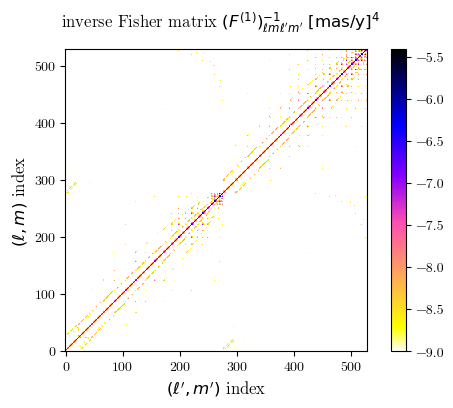

In [40]:
fig_mat_fisher1_inv = plt.figure(num=None, figsize=(6,4), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(np.log10(abs(mat_fisher1_inv+10**(-30))), origin='lower', vmin=-9, cmap = 'gnuplot2_r');
plt.suptitle('inverse Fisher matrix $(F^{(1)})^{-1}_{\ell m \ell^{\prime} m^\prime}$ $[\mathrm{mas/y}]^{4}$', fontsize=12)
plt.xlabel('$(\ell^\prime,m^\prime)$ index', fontsize=12)
plt.ylabel('$(\ell,m)$ index', fontsize=12)
plt.colorbar()
plt.show()
# fig_mat_fisher1_inv.savefig('mat_fisher1_inv.pdf')

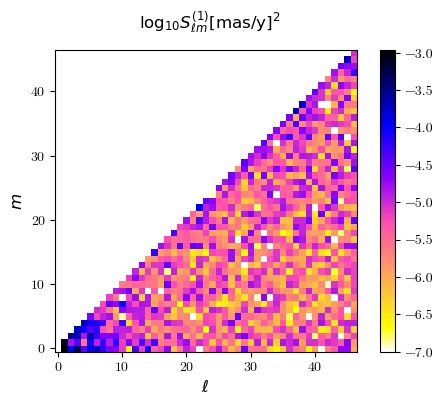

In [19]:
fig_pow1_spec = plt.figure(num=None, figsize=(6,4), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(np.log10(abs(fn_arr_pow_spec(mat_pow1_spec))),  origin='lower', vmin=-7, vmax=None, cmap='gnuplot2_r');
plt.suptitle('$\log_{10}S^{(1)}_{\ell m} [\mathrm{mas}/\mathrm{y}]^2$', fontsize=12)
plt.xlabel('$\ell$', fontsize=12)
plt.ylabel('$m$', fontsize=12)
plt.colorbar()
plt.show()
# fig_pow1_spec.savefig('pow1_spec.pdf')

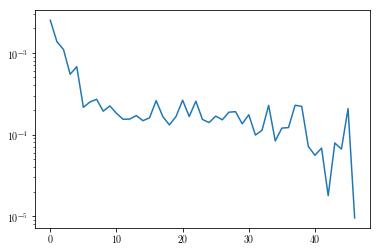

In [26]:
plt.plot(np.sum(abs(fn_arr_pow_spec(mat_pow1_spec)), axis=1))
plt.yscale("log")